# Feature Importance dos Autovalores do Kapetanovic

Nesse jupyter, o objeitivo é verificar quantos autovalores daquela mariz R a gnt pode usar pra fazer a detecção com machine learning. Nós começamos fazendo a razão entre o maior e o segundo maior autovalor. Depois, passamos de uma feature (razão) para duas (os dois maiores autovalores em si, sem fazer a razão). A detecção melhorou! Pois bem, então vamos usar mais autovalores né? Coloca o terceiro maior ai como feature então. Beleza, parece que melhorou mais um tótózinho. Então decidimos extrair TODOS os autovalores daquela matriz, e agora vamos ver até qual a gnt vai usar.

O dataset que a gnt vai usar pra verificar isso é composto por 256 antenas, 128 símbolos e 1 usuário conectado. SNR de -10 até 30 dB, passo 1. Potência do espião indo de 0 até 2.5, passo 0.5. Cada cenário tem repetibilidade 100. Como temos 128 símbolos, então são 128 autovalores na matriz R, logo, temos 128 + 3 features (autovalores + snr + E + eta). O E e o eta do Hassan vão ficar por ai msm pq a gnt já ta ligado que elas são as melhores features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from time import sleep, time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

não quero ter que ficar entrando na servidora toda hora pra ver se o algoritmo de gerar datasets já terminou kkkkk se vira ai mermão

In [2]:
# SO COMECA QUANDO O ALGORITMO DE GERAR OS DATASET TERMINAR
while os.path.isfile("../../CSV/dataset_256usuarios_256antenas_128simbolos_autovalores_completos.csv") == False:
    sleep(1 * 60)

In [3]:
#DEFININDO ALGUNS PARÂMETROS DO GRÁFICO
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
params = {
    'figure.figsize': [10, 5], 
    'axes.labelsize': 18,
    'axes.titlesize':20, 
    'font.size': 18,
    'legend.fontsize': 14, 
    'xtick.labelsize': 12, 
    'ytick.labelsize': 12,
    'axes.axisbelow': True
}
plt.rcParams.update(params)

## Definição de Funções

In [4]:
def treinarEClassificar(xTrain, xTest, yTrain, yTest, classificador):
    
    # INSTANCIANDO O CLASSIFICADOR
    objClassificador = eval(classificador)
    
    # TREINANDO
    objClassificador.fit(xTrain, yTrain)
    
    # PREDIZENDO
    yPred = objClassificador.predict(xTest)
    
    # RETORNANDO A ACURACIA
    return accuracy_score(yTest, yPred)

In [5]:
def salvarResultado(arquivoSalvar, nomeDataset, arrayAcuraciaMedia, arrayDesvioPadrao):
    objFile = open(arquivoSalvar, "a")
    objFile.write("Dataset: " + nomeDataset)
    objFile.write("\narrayAcuraciaMediaCadaQtdAutovaloresIgnorados = " + str(arrayAcuraciaMedia))
    objFile.write("\narrayDesvioPadraoAcuraciaCadaQtdAutovaloresIgnorados = " + str(arrayDesvioPadrao) + "\n\n")
    objFile.close()

## Parâmetros Iniciais

In [6]:
# TEMOS DATASETES COM QUAIS QTDs DE USUARIOS?
rangeQtdUsuarios = [1,2,4,8,16,32,64,128,256]

# CLASSIFICADOR PRA USAR NA AVALIACAO
classificador = "RandomForestClassifier(n_estimators=10, n_jobs=-1)"

# QTD DE ITERACOES DO K FOLD    
qtdFoders=5

# ARQUIVO DE SALVAR OS RESULTADOS
arquivoSalvar = "../../Resultados/featureImportanceAutovalores"+str(time())+".txt"

## Feature Importance

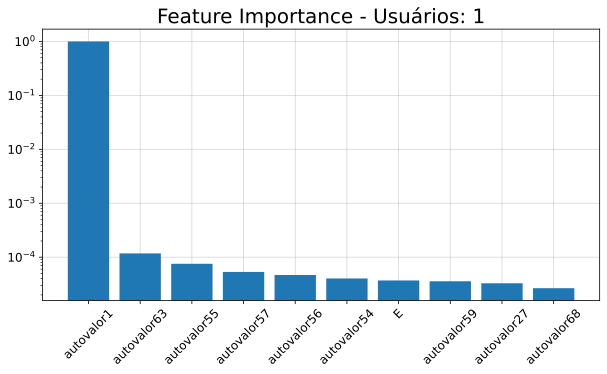

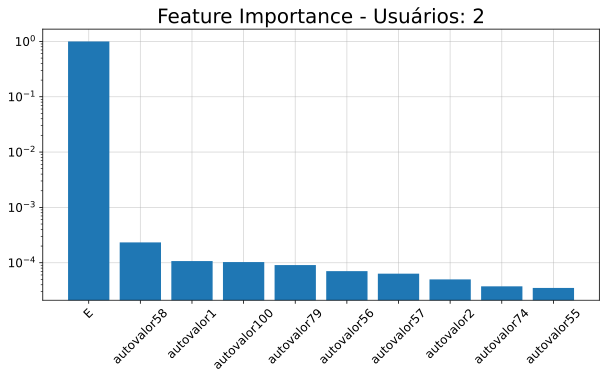

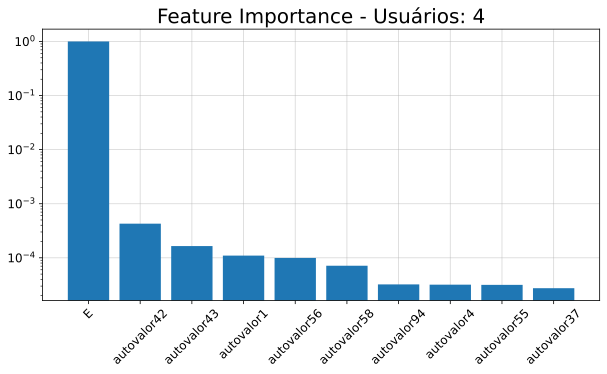

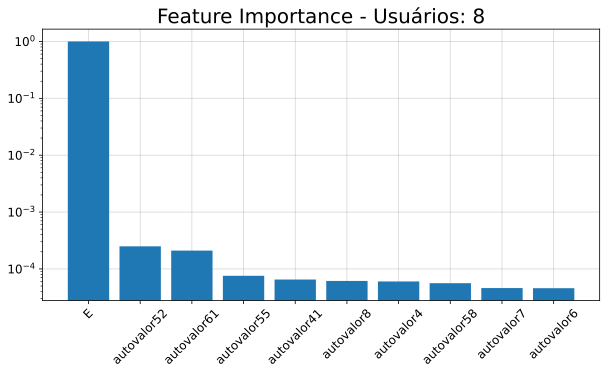

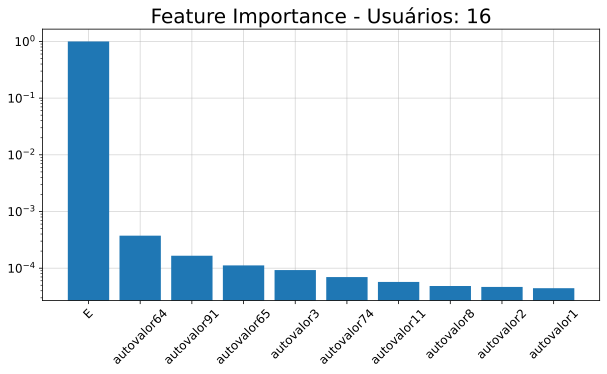

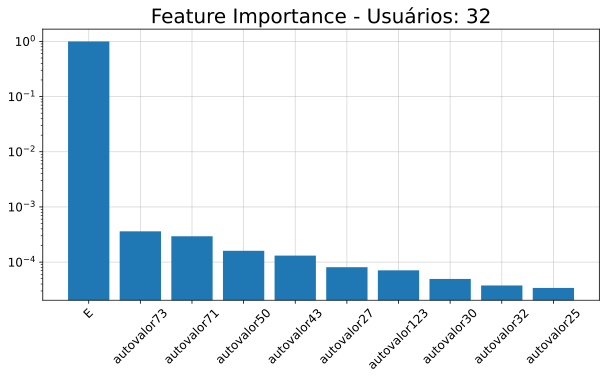

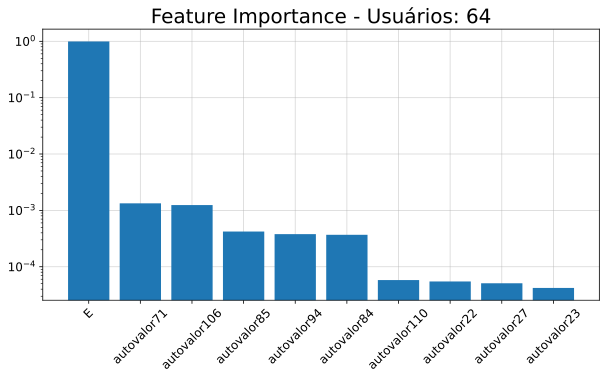

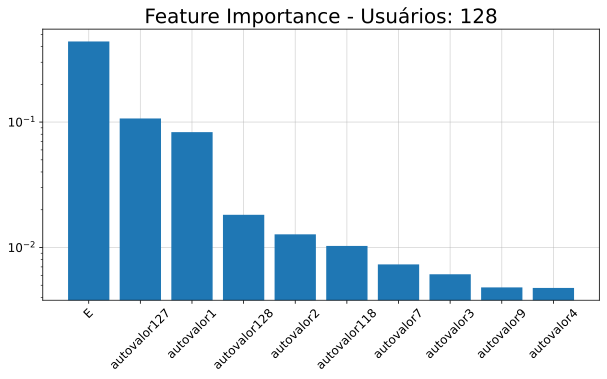

/media/murilo/Documentos/Dimitri/venvAICOM/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


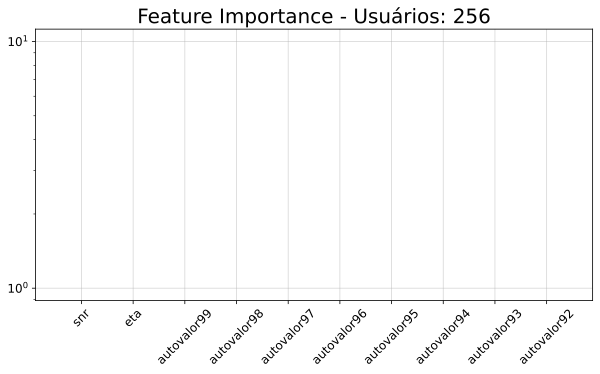

In [7]:
for qtdUsuariosAtual in rangeQtdUsuarios:
    
    # ABRINDO
    caminhoCSV = "../../CSV/dataset_" + str(qtdUsuariosAtual) + "usuarios_256antenas_128simbolos_autovalores_completos.csv"
    dataframe = pd.read_csv(caminhoCSV)  

    # SEPARANDO DATA, TARGET E FEATURES
    data    = dataframe.iloc[:, 0:-2].to_numpy()
    target  = dataframe.iloc[:, -1].to_numpy()
    colunas = list(dataframe.columns[:-2])

    # OBTENDO O VETOR DE IMPORTANCIA DAS FEATURES
    objDT = DecisionTreeClassifier()
    objDT.fit(data, target)
    arrayImportancias = objDT.feature_importances_

    # ORDENANDO DA MENOS IMPORTANTE PRA MAIS IMPORTANTE
    arrayImportancias, colunasOrdenadas = zip(*sorted(zip(arrayImportancias, colunas)))

    # PLOTANDO AS limite PRIMEIRAS
    limite = 10
    plt.bar(np.flip(colunasOrdenadas)[:limite], np.flip(arrayImportancias)[:limite])
    plt.title("Feature Importance - Usuários: "+str(qtdUsuariosAtual))
    plt.yscale("log")
    plt.xticks(rotation=45)
    plt.grid(alpha=0.5)
    plt.show()

## Abandonando os autovalores um por um

In [8]:
# MATRIZES QUE VAO GUARDAR OS ARRAYS DE ACURACIA MEDIA E DESVIO DE CADA QTD DE USUARIOS
matrizAcuraciasMediasCadaQtdUsuarios = []
matrizDesviosCadaQtdUsuarios         = []

# CADA QTD DE USUARIOS
for qtdUsuariosAtual in rangeQtdUsuarios:
    
    # ABRINDO
    caminhoCSV = "../../CSV/dataset_" + str(qtdUsuariosAtual) + "usuarios_256antenas_128simbolos_autovalores_completos.csv"
    dataframe = pd.read_csv(caminhoCSV)  

    # SEPARANDO DATA, TARGET E FEATURES
    data    = dataframe.iloc[:, 0:-2].to_numpy()
    target  = dataframe.iloc[:, -1].to_numpy()
    colunas = list(dataframe.columns[:-2])
    
#     # REDUZINDO O DATASET PARA TESTES
#     data, target = shuffle(data, target)
#     data   = data[:int(len(data)/100)] 
#     target = target[:int(len(target)/100)]
    
    # CRIANDO OS ARRAYS DE ACURACIA MEDIA E DESVIO QUE VAO GUARDAR EM CADA POSICAO O RESULTADO PARA A QTD DE AUTOVALORES IGNORADOS
    arrayAcuraciaMedia = []
    arrayDesvioPadrao  = []
    
    # DROPANDO UMA POR UMA DE CADA VEZ
    print("Usuários: "+str(qtdUsuariosAtual), end=" - Qtd features ignoradas: ")
    for i in range(1, len(colunas) - 2):
        
        # REDUZINDO A QTD DE FEATURES, DROPANDO COLUNA POR COLUNA
        data = np.delete(data, len(data[0])-1, axis=1)
        print(data.shape[1], end=" ")
        
        # ARRAY PRA GUARDAR AS ACURACIAS DOS KFOLDS DESSA QTD DE FEATURES
        acuraciasQtdFeaturesAtual = []
    
        # FAZENDO UM KFOLD
        objKFold = KFold(n_splits=qtdFoders, shuffle=True)
        for trainIndex, testIndex in objKFold.split(data):
            
            # SEPARANDO TREINAMENTO E TESTE
            xTrain, xTest, yTrain, yTest = data[trainIndex], data[testIndex], target[trainIndex], target[testIndex]
            
            # OBTENDO A ACURACIA DA ITERACAO ATUAL DO K FOLD
            acuraciasQtdFeaturesAtual.append(treinarEClassificar(xTrain, xTest, yTrain, yTest, classificador))
            
        # AGORA QUE TERMINOU O KFOLD PARA A QTD DE AUTOVALORES IGNORADOS DESSA ITERACAO, VOU GUARDAR A MEDIA E O DESVIO DA ACURACIA
        arrayAcuraciaMedia.append(np.mean(acuraciasQtdFeaturesAtual))
        arrayDesvioPadrao.append(np.std(acuraciasQtdFeaturesAtual))
        
    # COLOCANDO NA MATRIZ PRA PLOTAR DEPOIS E SALVANDO O RESULTADO
    salvarResultado(arquivoSalvar, caminhoCSV, arrayAcuraciaMedia, arrayDesvioPadrao)
    matrizAcuraciasMediasCadaQtdUsuarios.append(arrayAcuraciaMedia)
    matrizDesviosCadaQtdUsuarios.append(arrayDesvioPadrao)

Usuários: 1 - Qtd features ignoradas: 130 129 128 127 126 125 124 123 122 121 120 119 118 117 116 115 114 113 112 111 110 109 108 107 106 105 104 103 102 101 100 99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 Usuários: 2 - Qtd features ignoradas: 130 129 128 127 126 125 124 123 122 121 120 119 118 117 116 115 114 113 112 111 110 109 108 107 106 105 104 103 102 101 100 99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 Usuários: 4 - Qtd features ignoradas: 130 129 128 127 126 125 124 123 122 121 120 119 118 117 116 115 114 11

#### Printando

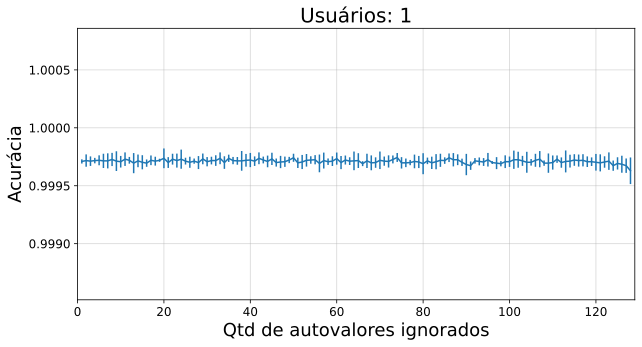

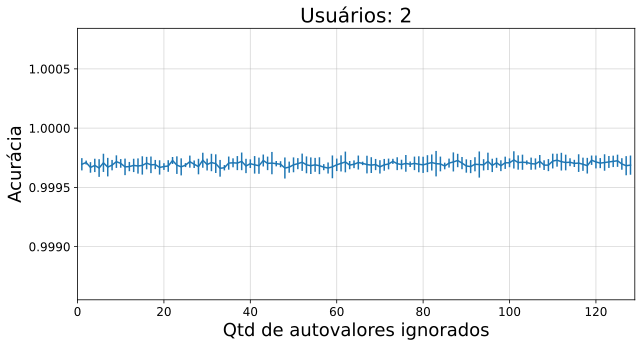

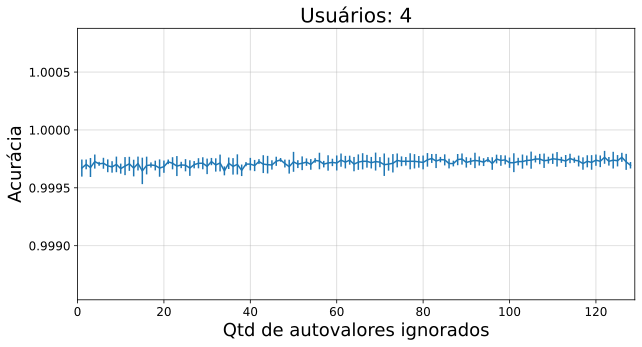

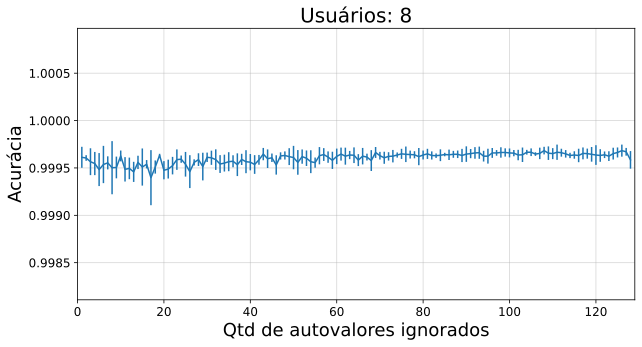

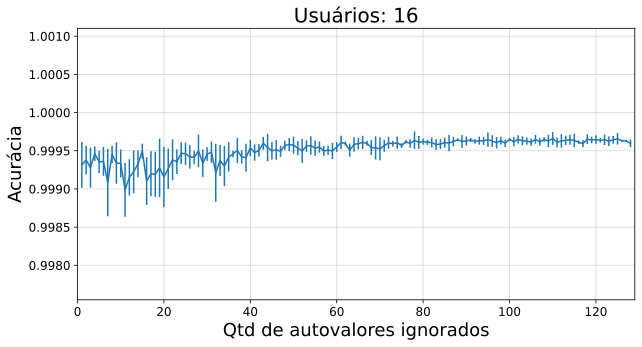

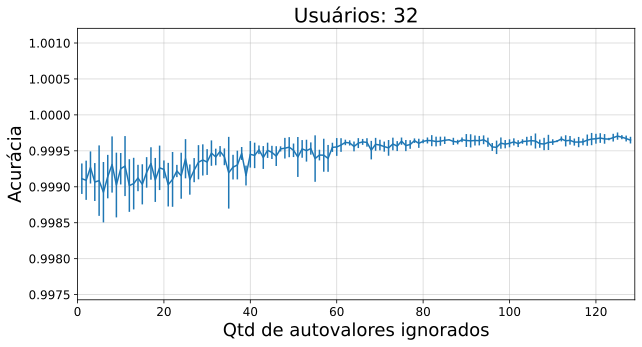

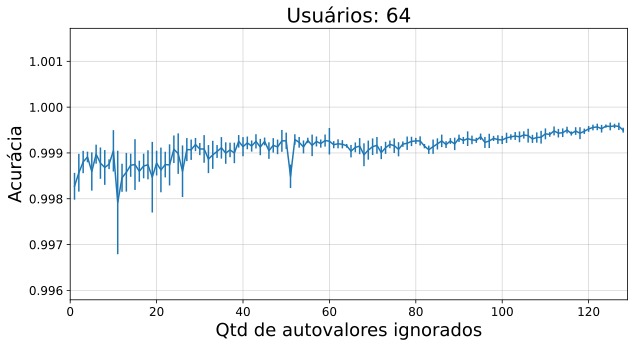

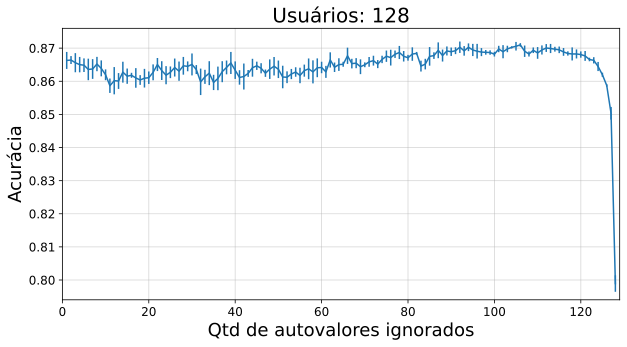

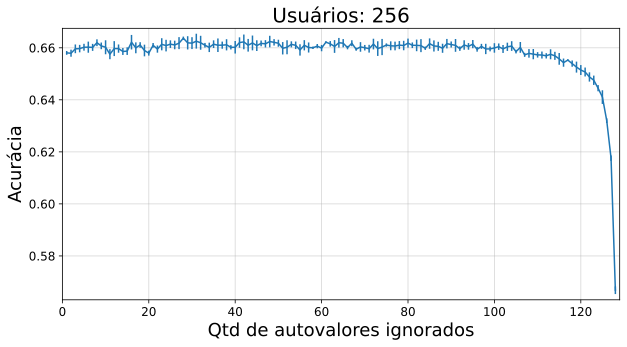

In [9]:
for i, qtdUsuariosAtual in enumerate(rangeQtdUsuarios):
    
    arrayAcuraciaMedia = matrizAcuraciasMediasCadaQtdUsuarios[i]
    arrayDesvioPadrao  = matrizDesviosCadaQtdUsuarios[i]
    
    plt.errorbar(x=np.arange(1,len(arrayAcuraciaMedia)+1), y=arrayAcuraciaMedia, yerr=arrayDesvioPadrao)
    plt.title("Usuários: "+str(qtdUsuariosAtual))
    plt.xlabel("Qtd de autovalores ignorados")
    plt.ylabel("Acurácia")
    plt.xlim(0,129)
    plt.ylim(0.999*(min(arrayAcuraciaMedia)-max(arrayDesvioPadrao)),1.001*(max(arrayAcuraciaMedia)+max(arrayDesvioPadrao)))
    plt.grid(alpha=0.5)
    plt.show()